In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import os.path

df = pd.read_csv(f"../input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv", index_col=None, header=0)
df['expiration']=pd.to_datetime(df['expiration'])
df['quote_date']=pd.to_datetime(df['quote_date'])
df['delta'] = df['delta'].abs()

#########################
# Settings for backtest #
#########################
min_delta = 0.60
# ot Option Type can be C or P (case-sensitive)
ot = 'P'

In [2]:
df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['strike'] = 0
df_trades['delta'] = 0.0

In [3]:
# Create new filtered dataframe with only calls above target delta
df_calls = df[(df['type']=="C") & (df['delta']>= min_delta) & (df['quote_time'] == '15:45:00') & (df['dte'] > 0)]
# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
df_calls = df_calls.loc[df_calls.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Only keep the min expiration date for each quote
df_calls = df_calls.loc[df_calls.groupby('quote_date')[['dte']].idxmin()['dte']]
df_calls.head()

,expiration,strike,type,close,bid,ask,price,delta,theta,quote_date,quote_time,dte
544,2021-01-06,3680.0,C,0.00,42.0,42.4,3700.80,0.6054,-7.4251,2021-01-04,15:45:00,2
1440,2021-01-06,3715.0,C,0.00,30.3,30.8,3729.77,0.6089,-10.4095,2021-01-05,15:45:00,1
2264,2021-01-08,3735.0,C,0.00,39.5,40.1,3753.83,0.6032,-7.0504,2021-01-06,15:45:00,2
3512,2021-01-08,3800.0,C,17.86,17.8,18.2,3808.65,0.6070,-6.1499,2021-01-07,15:45:00,1
4336,2021-01-11,3810.0,C,0.00,21.6,22.1,3821.43,0.6225,-2.4064,2021-01-08,15:45:00,1


In [4]:
# Create new filtered dataframe with only puts above target delta
df['delta'] = df['delta'].abs()
df_puts = df[(df['type']=="P") & (df['delta']>= min_delta) & (df['quote_time'] == '15:45:00') & (df['dte'] > 0)]
# We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
df_puts = df_puts.loc[df_puts.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
# Now that we're certain we have the minimum expiration date, get the minimum delta
df_puts = df_puts.loc[df_puts.groupby('quote_date')[['dte']].idxmin()['dte']]
df_puts.head()

,expiration,strike,type,close,bid,ask,price,delta,theta,quote_date,quote_time,dte
578,2021-01-06,3720.0,P,0.0,39.2,39.5,3700.80,0.6072,-6.6804,2021-01-04,15:45:00,2
1466,2021-01-06,3745.0,P,0.0,28.2,29.0,3729.77,0.6138,-9.3781,2021-01-05,15:45:00,1
2298,2021-01-08,3775.0,P,38.3,37.3,38.0,3753.83,0.6273,-5.9483,2021-01-06,15:45:00,2
3530,2021-01-08,3820.0,P,0.0,18.4,18.8,3808.65,0.6416,-5.5189,2021-01-07,15:45:00,1
4358,2021-01-11,3835.0,P,0.0,20.8,21.3,3821.43,0.6518,-2.0385,2021-01-08,15:45:00,1


In [5]:
def get_contract_strike(curr_date, contract_date, i_df):
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
       return pd.Series([0,0,0])
    return pd.Series([df1['strike'],df1['delta'],price])


def get_amount_lost(contract_date, strike, option_type):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['strike']==strike) & (df['type']==option_type) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    if option_type == 'P':
        diff = strike - underlying
    else:
        diff = underlying - strike
    if diff > 0.0:
        return diff*100
    return 0      

In [6]:
#Need to figure out how to extract strike, delta, and the average between bid/ask from one "apply" operation
df_trades['strike'],df_trades['delta'],df_trades['collected'] = df_trades.apply(lambda row : get_contract_strike(row['trade_date'], row['expiration'], df_calls if ot == 'C' else df_puts), axis = 1).T.values
df_trades['lost'] = df_trades.apply(lambda row : get_amount_lost(row['expiration'], row['strike'], ot), axis=1)
df_trades['net'] = df_trades['collected'] - df_trades['lost']


In [7]:
df_trades['net'] = df_trades['collected'] - df_trades['lost']

# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [8]:
df_trades.tail(40)

,expiration,trade_date,collected,lost,strike,delta,net
121,2021-10-08,2021-10-06,3580.0,0.0,4370.0,0.6111,3580.0
122,2021-10-11,2021-10-08,2190.0,4422.0,4405.0,0.6091,-2232.0
123,2021-10-13,2021-10-11,3355.0,2602.0,4390.0,0.6363,753.0
124,2021-10-15,2021-10-13,3040.0,0.0,4375.0,0.6238,3040.0
125,2021-10-18,2021-10-15,1745.0,0.0,4480.0,0.6234,1745.0
126,2021-10-20,2021-10-18,2170.0,0.0,4495.0,0.6265,2170.0
127,2021-10-22,2021-10-20,2030.0,0.0,4545.0,0.6496,2030.0
128,2021-10-25,2021-10-22,1635.0,0.0,4555.0,0.6502,1635.0
129,2021-10-27,2021-10-25,2035.0,2805.0,4580.0,0.6589,-770.0
130,2021-10-29,2021-10-27,2150.0,0.0,4575.0,0.6078,2150.0


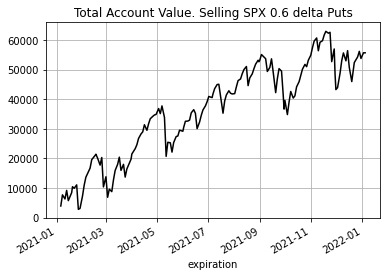

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
df_trade_plot.plot(ax=ax, style='k-')
plt.title(f"Total Account Value. Selling SPX {min_delta} delta {'Calls' if ot=='C' else 'Puts'}")
plt.grid()
plt.savefig(f"{min_delta}.png")